In [1]:
import matplotlib 
from matplotlib import pyplot as plt
import numpy as np
import scipy

In [2]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import animation
from IPython.display import HTML

In [4]:
import keras
import tensorflow as tf
# visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from deep_boltzmann.util import load_obj

Using TensorFlow backend.
/Users/noe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [5]:
matplotlib.rcParams.update({'font.size': 14})

In [8]:
paper_dir = '../'

Simulation
------

In [9]:
from deep_boltzmann.models.particle_dimer import ParticleDimer
from deep_boltzmann.sampling.metropolis import MetropolisGauss

In [10]:
# load trajectory data
trajdict = np.load(paper_dir + 'local_data/particles_tilted/trajdata_long.npz')
import ast
params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']

In [11]:
# create model
params['grid_k'] = 0.0
model = ParticleDimer(params=params)
print(model.params)

{'dimer_dmid': 1.5, 'box_halfsize': 3.0, 'grid_k': 0.0, 'rm': 1.1, 'box_k': 100.0, 'nsolvent': 36, 'eps': 1.0, 'dimer_b': 10.0, 'dimer_a': 25.0, 'dimer_slope': 2.0, 'dimer_k': 20.0}


(-5, 25)

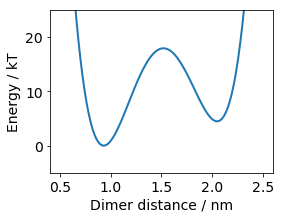

In [12]:
plt.figure(figsize=(4, 3))
model.plot_dimer_energy(plt.gca());
plt.xlabel('Dimer distance / nm')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])
plt.ylim(-5, 25)
#plt.savefig(paper_dir + 'figs/particle_dimer_potential.pdf', bbox_inches='tight')

In [13]:
etraj_closed_train = model.energy(traj_closed_train)
etraj_open_train = model.energy(traj_open_train)
etraj_closed_test = model.energy(traj_closed_test)
etraj_open_test = model.energy(traj_open_test)

Text(0,0.5,'Probability')

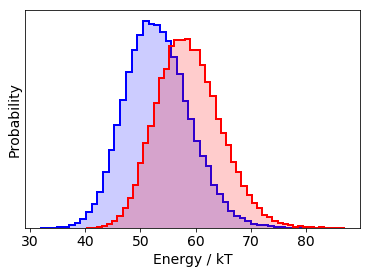

In [14]:
plt.hist(etraj_closed_train, 50, histtype='stepfilled', color='blue', alpha=0.2);
plt.hist(etraj_closed_train, 50, histtype='step', color='blue', linewidth=2);
plt.hist(etraj_open_train, 50, histtype='stepfilled', color='red', alpha=0.2);
plt.hist(etraj_open_train, 50, histtype='step', color='red', linewidth=2);
plt.xlabel('Energy / kT')
plt.yticks([])
plt.ylabel('Probability')

Text(0.5,0,'Probability')

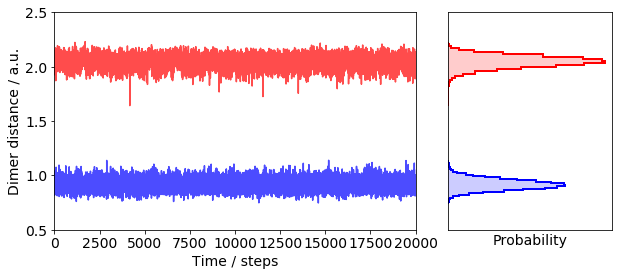

In [15]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(model.dimer_distance(traj_closed_train), color='blue', alpha=0.7)
ax1.plot(model.dimer_distance(traj_open_train), color='red', alpha=0.7)
ax1.set_xlim(0, 20000)
ax1.set_ylim(0.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('Dimer distance / a.u.')
ax2.hist(model.dimer_distance(traj_closed_train), 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(model.dimer_distance(traj_closed_train), 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(model.dimer_distance(traj_open_train), 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(model.dimer_distance(traj_open_train), 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0.5, 2.5)
ax2.set_xlabel('Probability')

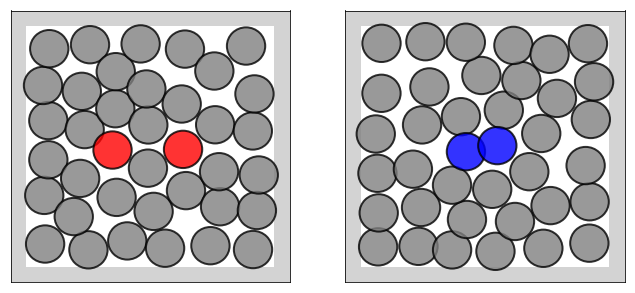

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
model.draw_config(traj_closed_train[0], axis=axes[1], dimercolor='blue', alpha=0.8);
model.draw_config(traj_open_train[2], axis=axes[0], dimercolor='red', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particle_MD_configurations.pdf', bbox_inches='tight')

In [17]:
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

Load and test
------

In [18]:
from deep_boltzmann.networks.invertible import EnergyInvNet
from deep_boltzmann.networks.plot import test_generate_x, test_xz_projection

In [26]:
network = EnergyInvNet.load('../local_data/particles_tilted/trained/network_0.pkl', model)

(-4, 4)

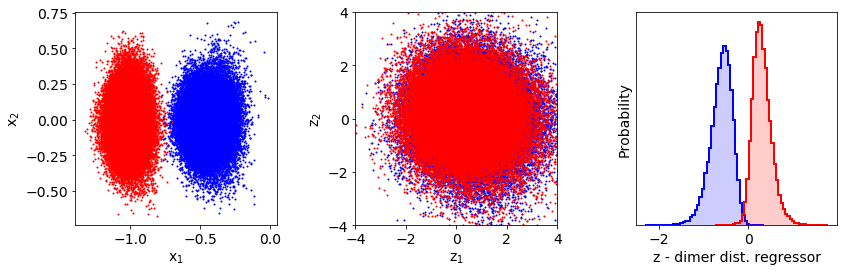

In [20]:
fig, axes = test_xz_projection(network.Txz, [traj_closed_train, traj_open_train], 
                               rctrajs=[model.dimer_distance(traj_closed_train), 
                                        model.dimer_distance(traj_open_train)],
                               subplots=np.array([True, True, False, True]), colors=['blue', 'red']);
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
#plt.savefig(paper_dir + 'figs/particle_transformation.pdf', bbox_inches='tight')

In [21]:
network.std_z(x)

1.1607614

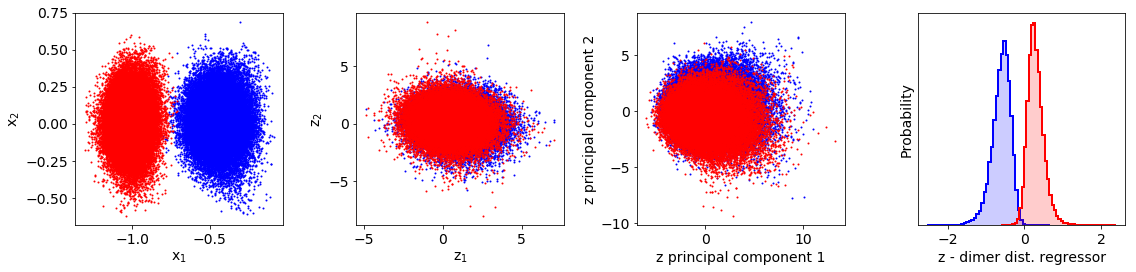

In [22]:
test_xz_projection(network.Txz, [traj_closed_test, traj_open_test], 
                   rctrajs=[model.dimer_distance(traj_closed_test), 
                            model.dimer_distance(traj_open_test)],
                   colors=['blue', 'red']);

In [23]:
network.std_z(xval)

1.2450315

In [27]:
bs_z_05, bs_x_05, bs_Ez_05, bs_Ex_05, bs_w_05 = network.sample(temperature=0.5, nsample=20000)
print(bs_Ex_05.min(), bs_Ex_05.max())
bs_z_10, bs_x_10, bs_Ez_10, bs_Ex_10, bs_w_10 = network.sample(temperature=1.0, nsample=20000)
print(bs_Ex_10.min(), bs_Ex_10.max())
bs_z_20, bs_x_20, bs_Ez_20, bs_Ex_20, bs_w_20 = network.sample(temperature=2.0, nsample=20000)
print(bs_Ex_20.min(), bs_Ex_20.max())

44.467254638671875 175.6656036376953
29.403430938720703 1074.8348388671875
20.102487564086914 2642.8828125


In [31]:
# round-trip time
from deep_boltzmann.util import count_transitions
n_transitions = count_transitions(model.dimer_distance(bs_x_10), 1.0, 2.0)
round_trip_time = 20000 / n_transitions
print(round_trip_time)

3.5001750087504373


Traj  0 Fraction of low energies:  1.0
Traj  0 Minimum energy:  46.67645263671875
Traj  1 Fraction of low energies:  1.0
Traj  1 Minimum energy:  46.67645263671875


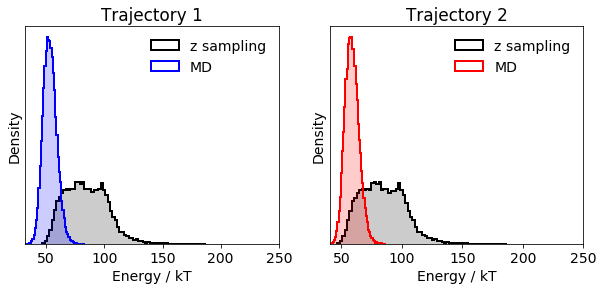

In [25]:
test_generate_x(model, [traj_closed_train, traj_open_train], bs_Ex_05, max_energy=250, colors=['blue', 'red']);

Traj  0 Fraction of low energies:  1.0
Traj  0 Minimum energy:  30.453433990478516
Traj  1 Fraction of low energies:  1.0
Traj  1 Minimum energy:  30.453433990478516


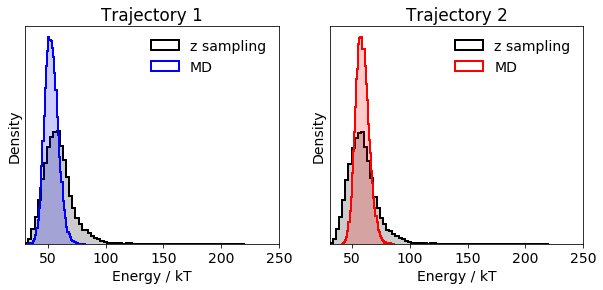

In [26]:
test_generate_x(model, [traj_closed_train, traj_open_train], bs_Ex_10, max_energy=250, colors=['blue', 'red']);

Traj  0 Fraction of low energies:  0.9988042568456296
Traj  0 Minimum energy:  30.70159912109375
Traj  1 Fraction of low energies:  0.9994422755158952
Traj  1 Minimum energy:  44.86962890625
Traj  2 Fraction of low energies:  0.9990063346168178
Traj  2 Minimum energy:  37.57801055908203


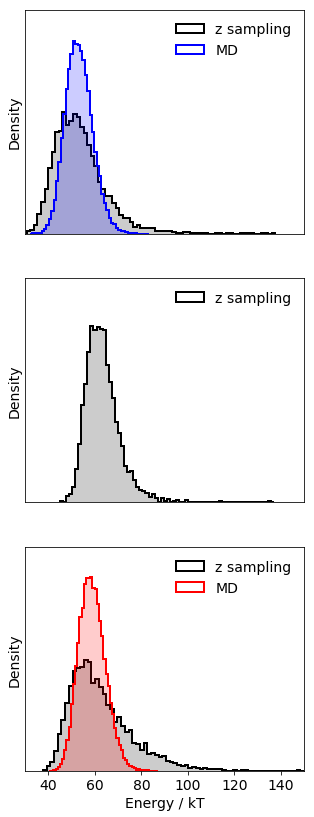

In [71]:
I_closed_10 = np.where(model.dimer_distance(bs_x_10) < 1.3)[0]
I_ts_10 = np.where(np.logical_and(model.dimer_distance(bs_x_10) > 1.3, model.dimer_distance(bs_x_10) < 1.7))[0]
I_open_10 = np.where(model.dimer_distance(bs_x_10) > 1.7)[0]

fig, axes = test_generate_x(model, 
                            [traj_closed_train, None, traj_open_train], 
                            [bs_Ex_10[I_closed_10], bs_Ex_10[I_ts_10], bs_Ex_10[I_open_10]], 
                            colors=['blue', 'yellow', 'red'],
                            max_energy=150, figsize=(5, 14), layout=(3, 1), titles=False);
axes[0].set_xlabel('')
axes[0].set_xticks([])
axes[0].set_xlim(30, 150)
axes[0].set_ylim(0, 0.08)
axes[1].set_xlabel('')
axes[1].set_xticks([])
axes[1].set_xlim(30, 150)
axes[1].set_ylim(0, 0.08)
axes[2].set_xlim(30, 150)
axes[2].set_ylim(0, 0.08)
#axes[2].set_ylabel('')
#plt.savefig(paper_dir + 'figs/particle_zsampling_energy.pdf', bbox_inches='tight')

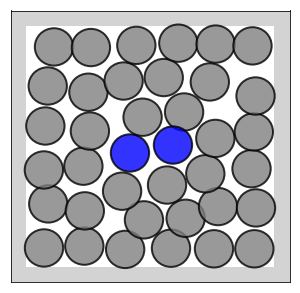

In [72]:
#fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 17))
model.draw_config(bs_x_10[I_closed_10, :][0], dimercolor='blue', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particle_zsampling_structure1.pdf', bbox_inches='tight')

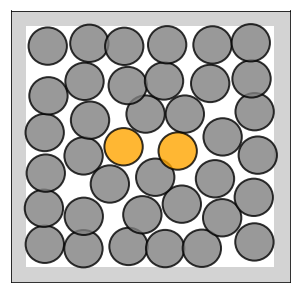

In [73]:
model.draw_config(bs_x_10[I_ts_10, :][0], dimercolor='orange', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particle_zsampling_structure2.pdf', bbox_inches='tight')

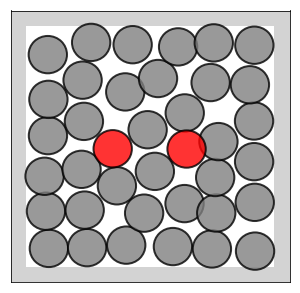

In [74]:
model.draw_config(bs_x_10[I_open_10, :][0], dimercolor='red', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particle_zsampling_structure3.pdf', bbox_inches='tight')

In [306]:
sample_energies = [bs_Ex_10 for i in range(2)]

In [311]:
energies_sample_x_low = [se[np.where(se < 100)[0]] for se in sample_energies]

In [ ]:
test_generate_x(model, [traj_open_train], bs_Ex_10, max_energy=250);

Traj  0 Fraction of low energies:  0.99945
Traj  0 Minimum energy:  20.216211318969727
Traj  1 Fraction of low energies:  0.99945
Traj  1 Minimum energy:  20.216211318969727


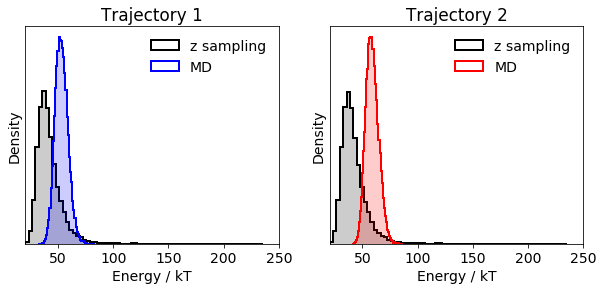

In [27]:
test_generate_x(model, [traj_closed_train, traj_open_train], bs_Ex_20, max_energy=250, colors=['blue', 'red']);

(30, 100)

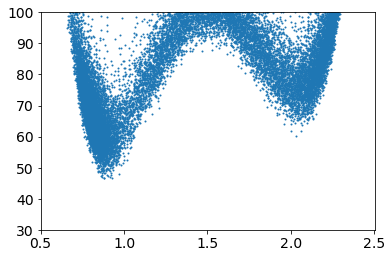

In [28]:
plt.plot(model.dimer_distance(bs_x_05), bs_Ex_05, linewidth=0, marker='.', markersize=2)
plt.ylim(30, 100)

(30, 100)

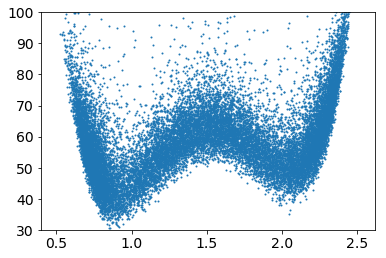

In [29]:
plt.plot(model.dimer_distance(bs_x_10), bs_Ex_10, linewidth=0, marker='.', markersize=2)
plt.ylim(30, 100)

(20, 100)

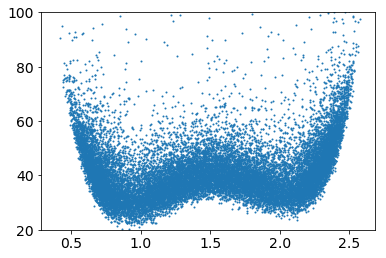

In [30]:
plt.plot(model.dimer_distance(bs_x_20), bs_Ex_20, linewidth=0, marker='.', markersize=2)
plt.ylim(20, 100)

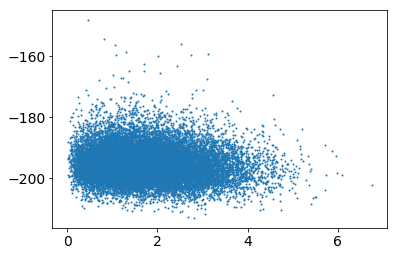

In [31]:
blind_sample_J = network.TzxJ.predict(bs_z_10)[1][:, 0]
plt.plot(model.dimer_distance(bs_z_10), blind_sample_J, linewidth=0, marker='.', markersize=2)

Sampling
----

In [22]:
from deep_boltzmann.util import count_transitions, acf
from deep_boltzmann.sampling.latent_sampling import GaussianPriorMCMC, plot_latent_sampling, eval_GaussianPriorMCMC, sample_RC
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite
from deep_boltzmann.util import load_obj, save_obj

In [27]:
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling

In [29]:
# Umbrella sampling - reference
us05 = UmbrellaSampling.load('../local_data/particles_tilted/us_T05_F.pkl')
us10 = UmbrellaSampling.load('../local_data/particles_tilted/us_T10_F.pkl')
us20 = UmbrellaSampling.load('../local_data/particles_tilted/us_T20_F.pkl')

In [30]:
umbrella_positions = us10.umbrella_positions
pmf_us05 = us05.umbrella_free_energies()
pmf_us10 = us10.umbrella_free_energies()
pmf_us20 = us20.umbrella_free_energies()
pmf_uss = [pmf_us05, pmf_us10, pmf_us20]

Model Averaging
------

In [46]:
# run training + analysis scripts to get this file 
many_sampled_distances = load_obj('../local_data/hydrocarbon_cyc9/trained/distances_sample.pkl')

In [47]:
many_sampled_distances.keys()

dict_keys(['D10', 'W10', 'W05', 'temperatures', 'W20', 'D05', 'D20'])

In [48]:
from deep_boltzmann.sampling.analysis import mean_finite, std_finite

In [49]:
def mean_free_energy(Ds, Ws):
    E = []
    ndrop=0
    for D, W in zip(Ds, Ws):
        # sort by descending weight
        I = np.argsort(W)[::-1]
        D_sorted = D[I][ndrop:]
        W_sorted = W[I][ndrop:]

        bins = np.linspace(0.5, 2.5, 30)
        bin_means = 0.5*(bins[:-1] + bins[1:])
        hist, _ = np.histogram(D_sorted, bins=bins, weights=np.exp(W_sorted))
        e = -np.log(hist)
        e -= np.concatenate([e[3:10],e[-10:-3]]).mean()
        E.append(e)
    E = np.array(E)
    return bin_means, mean_finite(E, axis=0, min_finite=2), std_finite(E, axis=0, min_finite=2)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


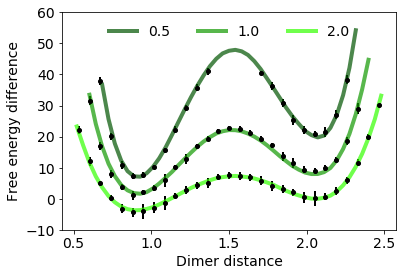

In [92]:
bm, mE, sE = mean_free_energy(many_sampled_distances['D05'], many_sampled_distances['W05'])
mE = cut_energy(mE, cut=35.0)
plt.plot(us05.rc_discretization, us05.rc_free_energies+6.2, linewidth=4, color='#005500', alpha=0.7, label='0.5')
plt.errorbar(bm, mE+20, sE, color='black', linewidth=0, marker='.', markersize=8, elinewidth=2)
#plt.fill_between(bm, mE+20-1*sE, mE+20+1*sE, color='blue', alpha=0.3)

bm, mE, sE = mean_free_energy(many_sampled_distances['D10'], many_sampled_distances['W10'])
mE = cut_energy(mE, cut=35.0)
plt.plot(us10.rc_discretization, us10.rc_free_energies+0.5, linewidth=4, color='#119900', alpha=0.7, label='1.0')
plt.errorbar(bm, mE+8.5, sE, color='black', linewidth=0, marker='.', markersize=8, elinewidth=2)
#plt.fill_between(bm, mE+8.5-1*sE, mE+8.5+1*sE, color='black', alpha=0.3)

bm, mE, sE = mean_free_energy(many_sampled_distances['D20'], many_sampled_distances['W20'])
mE = cut_energy(mE, cut=35.0)
plt.plot(us20.rc_discretization, us20.rc_free_energies-5.2, linewidth=4, color='#33FF00', alpha=0.7, label='2.0')
plt.errorbar(bm, mE, sE, color='black', linewidth=0, marker='.', markersize=8, elinewidth=2)
#plt.fill_between(bm, mE-1*sE, mE+1*sE, color='red', alpha=0.3)

plt.legend(loc=9, ncol=3, frameon=False)
plt.ylim(-10, 60)
plt.xlabel('Dimer distance')
plt.ylabel('Free energy difference')
#plt.savefig(paper_dir + 'figs/particle_free_energies_temp.pdf')